In [7]:
import random as r
import time
import numpy as np
from matplotlib import pyplot as plt

###########################################
# Application of the OFC model in python  #
# Evangelos Stogiannos                    #
###########################################

# neighboring_plates: function that receives the coordinates of the current grid
# cell and returns a list containing the coordinates of its neighbors


def neighboring_plates(i, j, n):
    plates = []
    if i-1 >= 0:
        plates.append([i-1, j])
    if i+1 < n:
        plates.append([i+1, j])
    if j-1 >= 0:
        plates.append([i, j-1])
    if j+1 < n:
        plates.append([i, j+1])
    return plates

# MAIN


def simulation(n, a, steps, force):
    limit = np.random.normal(0.5, 0.175, (n, n))  # Randomly generated limit for each grid cell
    grid = np.zeros((n, n))  # First iteration of the grid, filled with 0s
    current_step = 1  # current_step steps
    magnitude_list = []  # list of the broken cells in each current_step step
    total_force_list = []  # list of the total force of the grid in each current_step step

    # (ln 41~47) In each current_step step, add force to each cell in the grid
    # (ln 48~58) If a cell exceeds the limit and breaks, increase the magnitute by 1 and set it's force to 0.
    #            Set the flag to 1 and create x and y as the coordinates for the neighboring cells
    # (ln 59~71 )If at least a cell has been broken, repeat the above for each neighboring cell,
    #            changing the values of x and y to match the last broken cell's until no cell's meighnors
    #            have been broken. If no cells are broken the flag is set to 0 and the loop ends, moving
    #            on to the next current_step step

    t0 = time.time()
    while current_step < steps :
        curr_magnitude = 0  # number of broken cells
        grid += force
        for i in range(n):
            for j in range(n):
                if grid[i][j] > limit[i][j]:
                    curr_magnitude = curr_magnitude + 1
                    force_dissipated = grid[i][j] * a
                    grid[i][j] = 0
                    flag_broken = 1   # Flag for when a cell breaks. If the flag is 1 the force dissipation continues
                    x = i
                    y = j
                    while flag_broken == 1:
                        broken_neighbors = 0
                        for k in neighboring_plates(x, y, n):
                            grid[k[0]][k[1]] = grid[k[0]][k[1]] + force_dissipated
                            if grid[k[0]][k[1]] > limit[k[0]][k[1]]:
                                curr_magnitude = curr_magnitude + 1
                                force_dissipated = grid[k[0]][k[1]] * a
                                grid[k[0]][k[1]] = 0
                                broken_neighbors = broken_neighbors + 1
                                x = k[0]
                                y = k[1]
                        if broken_neighbors == 0:
                            flag_broken = 0

        total_force = sum(grid[t][s] for t in range(n) for s in range(n))  # sum of each cell's force
        current_step = current_step + 1
        magnitude_list.append(curr_magnitude)  # Add the number of broken cells in the list
        total_force_list.append(total_force) # Add the total force to the list
        # print("Step:", current_step, "Broken:", magnitude)
        # print("Total force", total_force)

    # Plot the sorted magnitude list
    magnitude_list.sort()
    mag_fig = Figure()
    axis = mag_fig.add_subplot(1, 1, 1)
    axis.plot(magnitude_list)
#     mag_fig = plt.plot(magnitude_list)

    # Plot the grid's total force in each current_step step
    force_fig = Figure()
    axis = force_fig.add_subplot(1, 1, 1)
    axis.plot(total_force_list)
#     force_fig = plt.plot(total_force_list)
    return mag_fig, force_fig

In [22]:
import random as r
import time
import numpy as np
from matplotlib import pyplot as plt

def neighboring_plates(i, j, n):
    neighbors = []
    if i-1 >= 0:
        neighbors.append([i-1, j])
    if i+1 < n:
        neighbors.append([i+1, j])
    if j-1 >= 0:
        neighbors.append([i, j-1])
    if j+1 < n:
        neighbors.append([i, j+1])
    return neighbors

class plate:
    def __init__(self, crit, force):
        self.crit = crit
        self.force = force
        self.broken = False
        
    def __add__(self, fout):
        self.addForce(fout)
        
    def isBroken(self):
        return self.broken
    
    def addForce(self, fout):
        self.force += fout
        if self.force > self.crit:
            self.broken = True
            force_diss = self.force / 4
            self.force = 0
            return force_diss
        return -1
            

def simulation(n, max_crit, max_steps, max_start_force, force):
    grid = np.array([[plate(crit=np.random.normal(1, max_crit), force=np.random.normal(0.0001, max_start_force)) for j in range(n)] for j in range(n)])
    time_step = 0
    magnitude_list = []
    curr_mag = 0
    
    while time_step < max_steps:
        for i in range(n):
            for j in range(n):
                force_diss = grid[i][j].addForce(force)
                if force_diss > 0:
                    curr_mag += 1
                    broken_neighbors = 0
                    for neigh in neighboring_plates(i,j,n):
                        x = neigh[0]
                        y = neigh[1]
                        force_diss_n = grid[x][y].addForce(force_diss)
                        if force_diss_n > 0:
                            curr_mag += 1

        total_force = sum(grid[i][j].force for j in range(n) for i in range(n))  # sum of each cell's force
        time_step = time_step + 1
        magnitude_list.append(curr_mag)  # Add the number of broken cells in the list

#     mag_fig = plt.Figure()
#     axis = mag_fig.add_subplot(1, 1, 1)
#     axis.plot(magnitude_list)
    plt.plot(magnitude_list)
    print(magnitude_list)
#     return mag_fig

In [15]:
from flask import Flask, render_template, request
import io
from flask import Response
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

app = Flask(__name__)

@app.route('/')
def index():
    return render_template("index.html")


@app.route('/ofc', methods=["POST"])
def results():
    n = request.form["n"]
    max_crit = request.form["max_crit"]
    steps = request.form["steps"]
    force = request.form["force"]
    max_start_force = request.form["max_start_force"]
    mag_fig = simulation(int(n), float(max_crit), int(steps), float(max_start_force), float(force))
    output = io.BytesIO()
    
    FigureCanvas(mag_fig).print_png(output)
    return Response(output.getvalue(), mimetype='image/png')


if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


[390, 828, 1266, 1704, 2142, 2580, 3018, 3456, 3894, 4332, 4770, 5208, 5646, 6089, 6532, 6975, 7418, 7861, 8304, 8747, 9190, 9633, 10076, 10519, 10962, 11409, 11852, 12295, 12741, 13184, 13627, 14070, 14513, 14956, 15399, 15842, 16285, 16730, 17173, 17616, 18065, 18508, 18951, 19394, 19837, 20280, 20723, 21166, 21610, 22056, 22502, 22948, 23394, 23840, 24286, 24732, 25184, 25630, 26076, 26522, 26968, 27414, 27865, 28318, 28771, 29224, 29678, 30131, 30584, 31038, 31491, 31944, 32397, 32850, 33305, 33758, 34212, 34670, 35128, 35586, 36044, 36502, 36960, 37418, 37879, 38337, 38795, 39253, 39711, 40169, 40627, 41085, 41546, 42009, 42476, 42939, 43402, 43865, 44328, 44791, 45254, 45719, 46187, 46658, 47126, 47597, 48065, 48533, 49001, 49469, 49937, 50407, 50878, 51349, 51817, 52285, 52753, 53221, 53689, 54157, 54625, 55093, 55561, 56029, 56497, 56965, 57438, 57912, 58387, 58862, 59337, 59812, 60287, 60766, 61241, 61720, 62195, 62674, 63150, 63625, 64100, 64575, 65050, 65525, 66000, 66475, 6

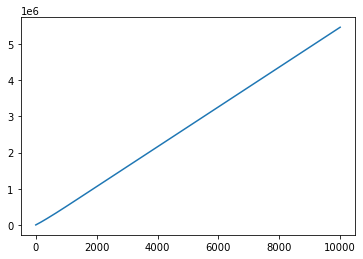

In [23]:
simulation(n=20, max_crit = 2, max_steps=10000, max_start_force=1, force=0.001)
# plt.plot(mag_fig)